# Projekt MSP1
Cílem tohoto projektu je se seznámit s programovými nástroji využívaných ve statistice a osvojit si základní procedury. Projekt není primárně zaměřen na efektivitu využívání programového vybavení (i když úplně nevhodné konstrukce mohou mít vliv na hodnocení), ale nejvíce nás zajímají vaše statistické závěry a způsob vyhodnocení. Dbejte také na to, že každý graf musí splňovat nějaké podmínky - přehlednost, čitelnost, popisky.

V projektu budete analyzovat časy běhu šesti různých konfigurací algoritmů. Ke každé konfiguraci vzniklo celkem 200 nezávislých běhů, jejichž logy máte k dispozici v souboru [logfiles.zip](logfiles.zip).

Pokud nemáte rozchozené prostředí pro pro spouštění Jupyter notebooku, můžete využití službu [Google Colab](https://colab.google/). Jakákoliv spolupráce, sdílení řešení a podobně je zakázána!

S případnými dotazy se obracejte na Vojtěcha Mrázka (mrazek@fit.vutbr.cz).

__Odevzdání:__ tento soubor (není potřeba aby obsahoval výstupy skriptů) do neděle 22. 10. 2023 v IS VUT. Kontrola bude probíhat na Pythonu 3.10.12; neočekává se však to, že byste používali nějaké speciality a nekompatibilní knihovny. V případě nesouladu verzí a podobných problémů budete mít možnost reklamace a prokázání správnosti funkce. Bez vyplnění vašich komentářů a závěrů do označených buněk nebude projekt hodnocen!

__Upozornění:__ nepřidávejte do notebooku další buňky, odpovídejte tam, kam se ptáme (textové komentáře do Markdown buněk)

__Tip:__ před odevzdáním resetujte celý notebook a zkuste jej spustit od začátku. Zamezíte tak chybám krokování a editací, kdy výsledek z buňky na konci použijete na začátku.

__OTÁZKA K DOPLNĚNÍ:__

Filip Jahn, xjahnf00

## Načtení potřebných knihoven
Načtěte knihovny, které jsou nutné pro zpracování souborů a práci se statistickými funkcemi. Není dovoleno načítat jiné knihovny.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from zipfile import ZipFile

## Načtení dat do DataFrame
Ze souboru `logfiles.zip` umístěném ve stejném adresáři načtěte data a vytvořte Pandas DataFrame.

Z logu vás budou nejvíce zajímat řádky
```
Configuration: config6
Run: 191
Time of run: 53.298725254089774
```

Můžete využít následující kostru - je vhodné pracovat přímo se ZIP souborem. Jedinou nevýhodou je to, že vám bude vracet _byte_ objekt, který musíte přes funkci `decode` zpracovat.

In [2]:
logfiles = "/content/logfiles.zip"
def load_logfile(f) -> dict:
    """Load a logfile from a file-like object and return a dict with the data."""
    data = {
        "conf": None,
        "run": None,
        "time": np.nan
    }

    log_data = f.read().decode("utf-8").strip().split('\n')
    data = {
        "conf": log_data[0].split(":")[1].strip(),
        "run": log_data[1].split(":")[1].strip(),
        "time": float(log_data[2].split(":")[1].strip()),
        "status": log_data[3].split(":")[1].strip()
    }
    return data

data = []
with ZipFile(logfiles) as zf:
    for filename in zf.namelist():
        with zf.open(filename, "r") as f:
            data.append(load_logfile(f))
df = pd.DataFrame(data)
df

,conf,run,time,status
0,config1,0,104.967142,SUCCESS
1,config1,1,98.617357,SUCCESS
2,config1,2,106.476885,SUCCESS
3,config1,3,115.230299,SUCCESS
4,config1,4,97.658466,SUCCESS
...,...,...,...,...
1195,config6,195,168.809495,SUCCESS
1196,config6,196,159.607244,SUCCESS
1197,config6,197,171.049799,SUCCESS
1198,config6,198,164.478283,SUCCESS


## Analýza a čištění dat
Vhodným způsobem pro všechny konfigurace analyzujte časy běhů a pokud tam jsou, identifikujte hodnoty, které jsou chybné.

Zvolil jsem grafický způsob analýzy za použití scatter plot, který dokáže zobrazit jednotlivé běhy konfigurací.

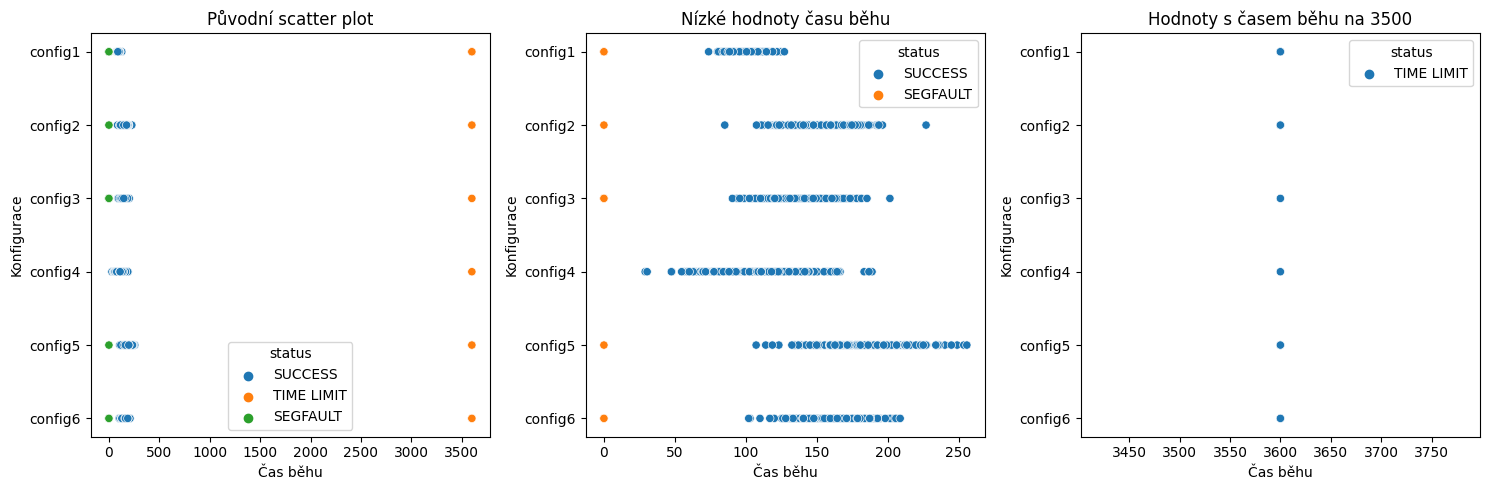

In [3]:
# Původní scatter plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='time', y='conf', hue='status', data=df)
plt.xlabel('Čas běhu')
plt.ylabel('Konfigurace')
plt.title('Původní scatter plot')

# Scatter plot pro nízké hodnoty
plt.subplot(1, 3, 2)
sns.scatterplot(x='time', y='conf', hue='status', data=df[df['time'] < 500])
plt.xlabel('Čas běhu')
plt.ylabel('Konfigurace')
plt.title('Nízké hodnoty času běhu')

# Scatter plot pro hodnoty s časem běhu na 3500
plt.subplot(1, 3, 3)
sns.scatterplot(x='time', y='conf', hue='status', data=df[df['time'] > 3500])
plt.xlabel('Čas běhu')
plt.ylabel('Konfigurace')
plt.title('Hodnoty s časem běhu na 3500')
plt.tight_layout()
plt.show()


__OTÁZKA K DOPLNĚNÍ:__

_Objevily se nějaké chybné hodnoty? Proč tam jsou s ohledem na to, že se jedná o běhy algoritmů?_

Z analýzy dat pomocí grafů můžeme jasně pozorovat dvě odlišné situace. Za prvé, některé běhy algoritmů skončily téměř okamžitě s chybou segmentation fault, a za druhé, některé běhy byly ukončeny kvůli nastavenému timeoutu.

Tato selhání mohou mít různé příčiny, včetně špatných vstupních argumentů, nadměrného objemu dat, který bylo nutné zpracovat, nebo i chybných míst v algoritmu, která se projevila pouze pro určité vstupy.

Vyčistěte dataframe `df` tak, aby tam tyto hodnoty nebyly a ukažte znovu analýzu toho, že čištění dat bylo úspěšné. Odtud dále pracujte s vyčištěným datasetem.

K odstranění odlehlých hodnot existují různé přístupy (např. IQR), v tomto případě se však zvolil méně matematický přístup a data se vyfiltrovala na základě hodnoty `STATUS`.

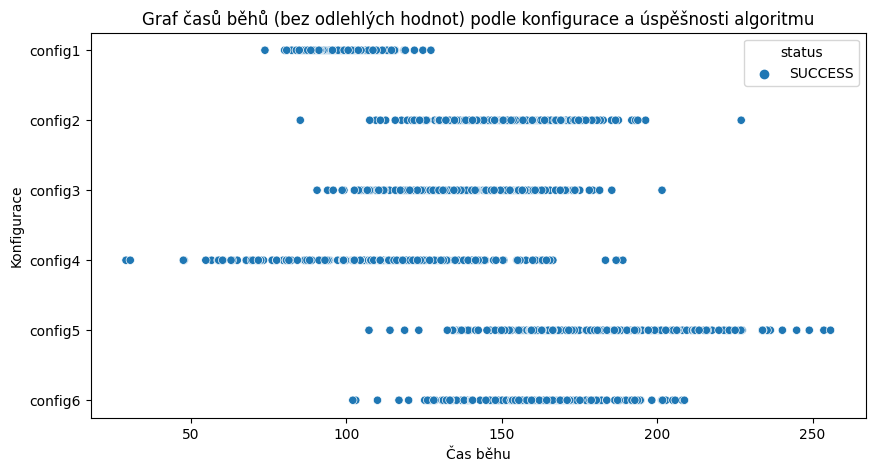

In [4]:
# Vyuzijeme toho, ze v datech se nachazi polozka status, ktera nam rika, ktera
# data jsou spravna a ktera ne
failed_runs = df[df['status'] != 'SUCCESS']
remove_failed = failed_runs.index.tolist()
cleared_runs = df.drop(remove_failed) # Smazani nespravnych behu

# Vytvoření grafu pouze pro vyčištěná data
plt.figure(figsize=(10, 5))
sns.scatterplot(x='time', y='conf', hue='status', data=cleared_runs)
plt.xlabel('Čas běhu')
plt.ylabel('Konfigurace')
plt.title('Graf časů běhů (bez odlehlých hodnot) podle konfigurace a úspěšnosti algoritmu')
plt.show()

## Deskriptivní popis hodnot
Vypište pro jednotlivé konfigurace základní deskriptivní parametry času pro jednotlivé konfigurace.  

__TIP__ pokud výsledky uložíte jako Pandas DataFrame, zobrazí se v tabulce.

In [5]:
cleared_runs.groupby('conf')['time'].describe()

,count,mean,std,min,25%,50%,75%,max
conf,,,,,,,,
config1,193.0,99.590413,9.386788,73.802549,92.979469,99.865028,104.824724,127.201692
config2,197.0,151.732975,19.833198,85.174653,137.995662,151.516091,163.802880,227.054630
config3,195.0,138.616959,19.867428,90.567110,124.803901,138.678404,151.536291,201.577616
config4,199.0,110.317016,30.656816,29.093401,88.742158,110.782732,130.665606,188.971462
config5,197.0,183.659767,28.729836,107.283620,164.070091,183.843132,201.250693,255.807973
config6,196.0,162.829359,20.648193,102.074892,149.917475,163.990098,177.730865,208.795048


__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte, co všechno můžeme z parametrů vyčíst._

- Sloupec `count` udává počet běhů pro danou konfiguraci.
- Sloupec `mean` nám říká střední hodnotu, která se vypočítá jako sečtení všech časů běhů a podělení počtem běhů.
- Ve sloupci `std` najdeme směrodatnou odchylku, která značí o kolik se v průměru pohybujeme od střední hodnoty.
- Ve sloupci `min` pak můžeme najít nejrychlejší běh algoritmu pro danou konfiguraci.
- Ve sloupci `25%` nalezneme hodnotu, pod kterou spadá 25% nejnižších hodnot.
- Ve sloupci `75%` nalezneme hodnotu, pod kterou spadá 75% nejvyšších hodnot.
- Ve sloupci mezi nimi, tedy `50%` je zapsána hodnota mediánu = prostřední hodnoty.
- Ve sloupci `max` konečně můžeme najít nejpomalejší běh algoritmu pro danou konfiguraci.

Z této tabulky můžeme vyčíst statistiky pro jednotlivé konfigurace. Vezmeme-li kupříkladu konfiguraci 1 a 2 pro srovnání, druhá konfigurace má v průměru mnohem delší čas, než konfigurace první. Rovněž standardní odchytlka je u druhé konfigurace větší než u první. A to nám může napovědět, že výkon první konfigurace je z pohledu délky běhu mnohem lepší než je tomu u konfigurace druhé.

## Vizualizace
Vizualizujte časy běhů algoritmů v jednom kompaktním grafu tak, aby byl zřejmý i rozptyl hodnot. Zvolte vhodný graf, který pak níže komentujte.

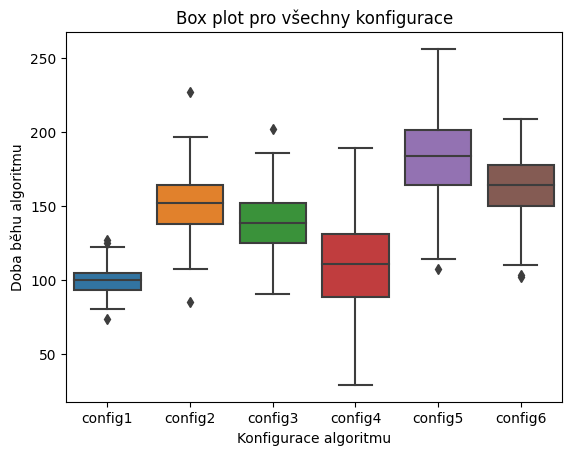

In [6]:
sns.boxplot(x='conf', y='time', data=cleared_runs)

plt.title('Box plot pro všechny konfigurace')
plt.xlabel('Konfigurace algoritmu')
plt.ylabel('Doba běhu algoritmu')

plt.show()

__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte  výsledky z tabulky._

Zvolil jsem box plot graf, na kterém jde dobře vidět, které konfigurace mají jaký rozptyl hodnot. Nejlépe to tedy vypadá na konfiguraci číslo 1 a 4. Konfigurace č.1 je stabilnější, ale konfigurace č.4 zase dokáže vykonat program mnohem rychleji (ovšem i mnohem pomaleji).

## Určení efektivity konfigurací algoritmů
Nás ale zajímá, jaká konfigurace je nejrychlejší. Z výše vykresleného grafu můžeme vyloučit některé konfigurace. Existuje tam však minimálně jedna dvojice, u které nedokážeme jednoznačně určit, která je lepší - pokud nebudeme porovnávat pouze extrémní hodnoty, které mohou být dané náhodou, ale celkově. Proto proveďte vhodný test významnosti - v následující části diskutujte zejména rozložení dat (i s odkazem na předchozí buňky, variabilitu vs polohu a podobně). Je nutné každý logický krok a výběry statistických funkcí komentovat. Můžete i přidat další buňky.

Vužijte vhodnou funkci z knihovny `scipy.stats` a funkci poté __implementujte sami__ na základě základních matematických funkcí knihovny `numpy` případně i funkcí pro výpočet studentova rozložení v [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html). Při vlastní implementaci není nutné se primárně soustředit na efektivitu výpočtu (není potřeba využít všechny funkce numpy, můžete použít normální cykly a podobně - v hodnocení však bude zahrnuta přehlednost a neměly by se objevit jasné chyby, jako je zvýšení třídy složitosti a podobně).

__OTÁZKA K DOPLNĚNÍ:__

_Jaká data budete zkoumat? Jaké mají rozložení a parametry (např. varianci) a jaký test použijete? Jaká je nulová hypotéza? Jak se liší variabilita a poloha vybraných konfigurací?_

Budou se zkoumat data konfigurace 1 a 4.

_Jaká je nulová hypotéza?_

Z box plot grafu lze odhadnout, že 1. první konfigurace bude lehce efektivnější než ta 4. Zavedeme si tedy nulovou a alternativní hypotézu následovně:

$$
H_0: \mu_1 \ge \mu_4
$$

$$
H_A: \mu_1 < \mu_4 ; W = \{ T: T \le -t_{1-\alpha}(v)\}
$$

Jestliže nulovou hypotézu zamítneme, můžeme říci, že 1. konfigurace nám v průměru opravdu dává lepší výsledky (tj. má kratší dobu běhu algoritmu).

Pro určení zamítnutí hypotézy lze použít [p-value](https://en.wikipedia.org/wiki/P-value). Platí, že jestliže je tato hodnota menší než hladina spolehlivosti $\alpha$ (v našem případě 0.01), zamítáme nulovou hypotézu a platí hypotéza alternativní.

Manuálně lze dosazením do $W = \{ T: T \le -t_{1-\alpha}(v)\}$ zjistit, zdali naše vypočtená hodnota $T$ spadá do kritického oboru. Hodnotu $-t_{1-\alpha}(v)$ zjistíme z tabulky t-rozdělení na základě zvolené hladiny spolehlivosti a vypočtených stupňů volnosti.


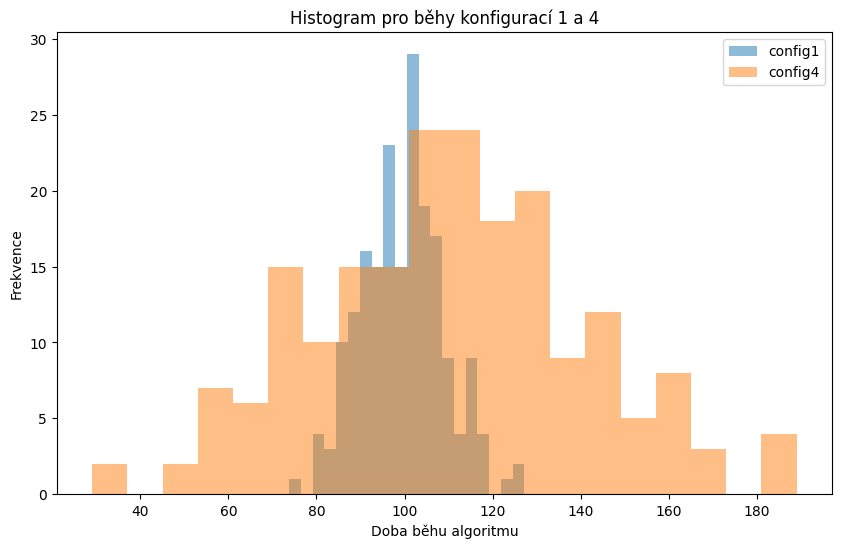

In [7]:
# Data pro konfigurace config1 a config4
config1_data = cleared_runs[cleared_runs["conf"] == "config1"]["time"]
config4_data = cleared_runs[cleared_runs["conf"] == "config4"]["time"]


# Vytvoření histogramu pro porovnání rozložení
plt.figure(figsize=(10, 6))
plt.hist(config1_data, bins=20, alpha=0.5, label='config1')
plt.hist(config4_data, bins=20, alpha=0.5, label='config4')
plt.xlabel('Doba běhu algoritmu')
plt.ylabel('Frekvence')
plt.title('Histogram pro běhy konfigurací 1 a 4')
plt.legend(loc='upper right')

plt.show()

In [8]:
ttest_ind = stats.ttest_ind(config1_data, config4_data, equal_var=False, alternative="less")
ttest_ind

TtestResult(statistic=-4.713292868840319, pvalue=2.0843410569946737e-06, df=235.8572821440884)

Hodnota -4.713 je výsledná hodnota statistiky provedeného t-testu. Nyní bychom mohli použít tabulky t-rozdělení a získat (i na základě stupňů volnosti) tabulkovou hodnotu. Na základě její hodnoty zjistíme, zda hodnota spadá do kritického oboru.

Hodnota p-value je vysvětlena výše a též lze využít pro zamítnutí/nezamítnutí nulté hypotézy.

---

*Jaký je závěr statistického testu?*

Zamítáme nulovou hypotézu, přijímáme alternativní hypotézu.

$H_1: \mu_1 \lt \mu_4 ; W = \{ T: T \le -t_{1-\alpha}(v)\}$

kde $T = -4,713$, hodnota z tabulky je $t_{0.99}(235) = 2.342$ při $α = 0.01$, tj. platí $-4,713 \le -2.342$. **Výsledkem testu tedy je, že konfigurace 1 bude rychlejší než konfigurace 4.**

In [9]:
# Prumer pro konfigurace
config1_mean = np.mean(config1_data, axis=0)
config4_mean = np.mean(config4_data, axis=0)

# Pocty hodnot
config1_cnt = len(config1_data)
config4_cnt = len(config4_data)

# Odhady rozptylu
config1_dispersion = (1 / (config1_cnt - 1)) * (np.sum(config1_data**2) - config1_cnt * config1_mean**2)
config4_dispersion = (1 / (config4_cnt - 1)) * (np.sum(config4_data**2) - config4_cnt * config4_mean**2)

# Testovaci statistiky
ttest = (config1_mean - config4_mean)/(np.sqrt( config1_dispersion/config1_cnt + config4_dispersion/config4_cnt ))

# Pocty stupnu volnosti
deg_freedom = np.floor((config1_dispersion / config1_cnt + config4_dispersion / config4_cnt)**2 / ((config1_dispersion / config1_cnt)**2 / (config1_cnt - 1) + (config4_dispersion / config4_cnt)**2 / (config4_cnt - 1)))

# Hodnota t
alpha = 0.01
t_value = stats.t.ppf(1 - alpha, deg_freedom)

print(f"Testovací statistika: {ttest} a hodnota t: {t_value}")
print("------------------------------------------------")
if (ttest <= -t_value):
  print("Zamítáme nultou hypotézu a platí alternativní hypotéza.")
else:
  print("Nezamítáme nultou hypotézu, ale alternativní hypotéza se však také neprokázala.")

Testovací statistika: -4.713292868840317 a hodnota t: 2.3423203662983996
------------------------------------------------
Zamítáme nultou hypotézu a platí alternativní hypotéza.
